In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from scipy.stats import binom, norm
from ppi_py.datasets import load_dataset
from ppi_py import ppi_distribution_label_shift_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

# Import the plankton data set

In [2]:
dataset_folder = './data/'
data = load_dataset(dataset_folder, 'plankton')
Y = data['Y'].astype(bool)
Yhat = data['Yhat'].astype(bool)
Y_unlabeled = data['Y_unlabeled'].astype(bool)
Yhat_unlabeled = data['Yhat_unlabeled'].astype(bool)

# Problem setup

In [3]:
alpha = 0.05 # Total error budget
delta = 0.048 # Rectifier budget
K = 2 # Total number of classes
nu = np.array([0,1]) # Linear contrast to estimate
n_total = Y.shape[0] # Total number of labeled examples
N = Y_unlabeled.shape[0] # Total number of unlabeled examples
ns = np.linspace(1000,n_total,20).astype(int) # Test for different numbers of labeled examples
num_trials = 50

# True mean (computed on all labels)
true_theta = Y_unlabeled.sum()

# Construct intervals

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
np.random.seed(0)
counter = 0
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        myhash_idx = np.sqrt(rand_idx * np.arange(n_total)).mean()
        _Yhat = Yhat[rand_idx[:n]]
        _Y = Y[rand_idx[:n]]
        
        ppi_count_ci = ppi_distribution_label_shift_ci(_Y, _Yhat, Yhat_unlabeled, K, nu, alpha, delta, counter, return_counts=True)
        # Append results
        results += [pd.DataFrame([{
            "method": "PPI",
            "n": n,
            "lower": ppi_count_ci[0],
            "upper": ppi_count_ci[1],
            "trial": j,
        }])]
        counter += 1
        
# Imputed CI
imputed_ci = classical_mean_ci(Yhat_unlabeled > 0.5, alpha=alpha)

results += [pd.DataFrame([{
    "method": "Imputation",
    "n": np.nan,
    "lower": imputed_ci[0]*N,
    "upper": imputed_ci[1]*N,
    "trial": 0,
}])]

df = pd.concat(results,axis=0,ignore_index=True)
df['width'] = df['upper'] - df['lower']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.12it/s]


# Plot results

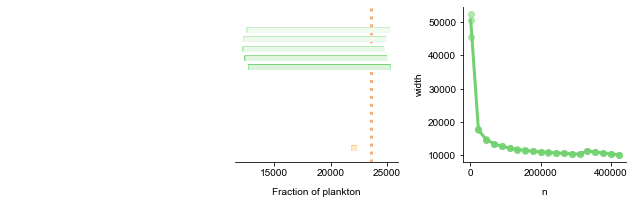

In [5]:
make_plots(df, './plots/plankton.pdf', n_idx=4, intervals_xlabel="Fraction of plankton", plot_classical=False, true_theta=true_theta)